In [1]:
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

pd.set_option('display.max_columns', 999)

# Introduction

In this notebook, we will explore the data from Petfinder.my that we'll use to predict adoption speed for individual pet listings. The layout of the notebook is as follows:

1. Data contents overview
2. 
3. A summary of notable EDA findings and thoughts on modeling implications.

# Data overview

We have access to four different types of data. All have been split into training and test sets.

1. Information on each adoption listing (tabular, one row per listing)
2. Images that were posted with each listing (JPG files)
3. Corresponding image metadata from the [Google Vision API](https://cloud.google.com/vision/docs/reference/rest/v1/images/annotate) (JSON files)
4. Sentiment analysis applied to each listing's description via the [Google Natural Language API](https://cloud.google.com/natural-language/docs/basics) (JSON files)

Also provided were some supplementary data mapping IDs to text names for certain fields in the tabular data - namely breed IDs to breed names, color IDs to color names, and state IDs to names of states in Malaysia.

## Which data are present for which listings?

The documentation tells us that not all listings will have all types of data. For example, there are some descriptions that could not be analyzed by Google's API. We'd like to use all the information available to us, so it will be useful to know how many of the listings are missing certain data types, and whether the data types are missing at random or according to some pattern.

In [2]:
def calc_data_info(datadir, split):
    if split not in ['train', 'test']:
        raise ValueError
    
    if split == 'train':
        tab = pd.read_csv(datadir / 'train.csv', index_col='PetID')
    else:
        # test.csv comes in an extra subfolder for some reason
        tab = pd.read_csv(datadir / 'test' / 'test.csv', index_col='PetID')
    
    images = (datadir / f'{split}_images').glob('*.jpg')
    metadata = (datadir / f'{split}_metadata').glob('*.json')
    sentiment = (datadir / f'{split}_sentiment').glob('*.json')
    
    image_cts = pd.Series(Counter(f.stem.split('-')[0] for f in images), 
                          name='Image count')
    metadata_cts = pd.Series(Counter(f.stem.split('-')[0] for f in metadata), 
                             name='Metadata count')
    sentiment_cts = pd.Series(Counter(f.stem for f in sentiment),
                              name='Sentiment count')
    
    data_info = tab[['PhotoAmt']].merge(image_cts, how='left', left_index=True, right_index=True)
    data_info = data_info.merge(metadata_cts, how='left', left_index=True, right_index=True)
    data_info = data_info.merge(sentiment_cts, how='left', left_index=True, right_index=True)
    data_info = data_info.fillna(0).astype(int)
    
    data_info['Has images'] = data_info['Image count'] > 0
    data_info['Has metadata'] = data_info['Metadata count'] > 0
    data_info['Has all metadata'] = data_info['Image count'] == data_info['Metadata count']
    data_info['Has sentiment'] = data_info['Sentiment count'] > 0
    
    return data_info

In [3]:
datadir = Path('../data')

In [4]:
train_data_info = calc_data_info(datadir, 'train')

In [5]:
test_data_info = calc_data_info(datadir, 'test')

The table output by `calc_data_info()` contains information about the presence of data for each listing.

* **`PhotoAmt`**: the number of photos for a listing is given as a feature in the tabular data. We keep it here to compare to the number of photos present in the image data. It's possible that a listing has images that were not supplied with the actual image data, and we want to know if that happens and how frequent it is.
* **`Image count`**: the number of image files present for each listing. We expect this to be the same as `PhotoAmt`, but we aren't sure yet if that's the case.
* **`Metadata count`**: the number of image metadata files present for each listing. This ought to be the same as `Image count`, but if there are images the Google API couldn't analyze for whatever reason, it may be less.
* **`Sentiment count`**: the number of sentiment analyis files present for each listing. There is only one description per listing, so this value should only ever be 1 or 0.
* **`Has images`**: `True` if there are images present for the listing, `False` otherwise
* **`Has metadata`**: `True` if there is image metadata present for the listing, `False` otherwise
* **`Has all metadata`**: `True` if a metadata file exists for each image, `False` if there are missing files
* **`Has sentiment`**: `True` if sentiment analysis is present for the listing, `False` otherwise

In [6]:
train_data_info.head()

,PhotoAmt,Image count,Metadata count,Sentiment count,Has images,Has metadata,Has all metadata,Has sentiment
PetID,,,,,,,,
86e1089a3,1,1,1,1,True,True,True,True
6296e909a,2,2,2,1,True,True,True,True
3422e4906,7,7,7,1,True,True,True,True
5842f1ff5,8,8,8,1,True,True,True,True
850a43f90,3,3,3,1,True,True,True,True


In [7]:
test_data_info.head()

,PhotoAmt,Image count,Metadata count,Sentiment count,Has images,Has metadata,Has all metadata,Has sentiment
PetID,,,,,,,,
e2dfc2935,2,2,2,1,True,True,True,True
f153b465f,1,1,1,1,True,True,True,True
3c90f3f54,4,4,4,1,True,True,True,True
e02abc8a3,5,5,5,1,True,True,True,True
09f0df7d1,5,5,5,1,True,True,True,True


### Training data

Let's look at the training data first. First of all, there are 14,993 total listings.

In [8]:
len(train_data_info)

14993

We have 58,311 images, and 97% of listings (14,652 of 14,993) contain at least one image.

In [9]:
train_data_info['Image count'].sum()

58311

In [10]:
train_data_info['Has images'].sum()

14652

Every listing has image metadata if and only if it has images.

In [11]:
pd.crosstab(train_data_info['Has images'], train_data_info['Has metadata'], dropna=False)

Has metadata,False,True
Has images,,
False,341,0
True,0,14652


Every listing has the same number of metadata files as it does image files.

In [12]:
train_data_info['Has all metadata'].value_counts()

True    14993
Name: Has all metadata, dtype: int64

94% of the listings (14,111 of 14,993) have images, metadata, and sentiment analysis. Only 10 have none of the three.

In [13]:
pd.crosstab(train_data_info['Has metadata'], train_data_info['Has sentiment'], dropna=False)

Has sentiment,False,True
Has metadata,,
False,10,331
True,541,14111


The following figure is a heatmap of the True and False values in `train_data_info`. The listings are organized along the $x$ axis. If a listing does not have one of the three non-tabular data types, a thin vertical black bar appears. Notice that once again we see listings are either missing both images and metadata, or neither. There does not appear to be a pattern between listings that are missing sentiment analysis and listings that are missing image metadata.

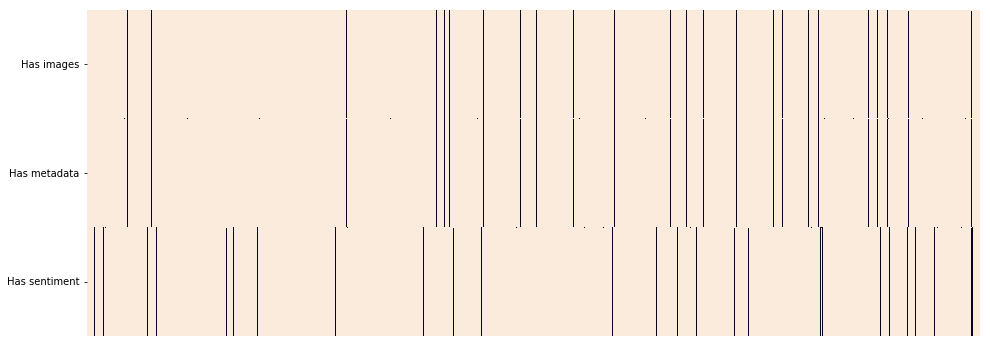

In [14]:
plt.figure(figsize=(16, 6))
cols = ['Has images', 'Has metadata', 'Has sentiment']
sns.heatmap(train_data_info[cols].sort_index().values.T,
            xticklabels=False,
            yticklabels=cols,
            cbar=False)
plt.yticks(rotation=0, va='center')
plt.ylabel(None)
plt.show()

### Test data

Next we'll inspect the test data. First of all, there are 3,972 total listings.

In [15]:
len(test_data_info)

3972

We have 14,465 images, and 97% of listings (3,858 of 3,972) contain at least one image.

In [16]:
test_data_info['Image count'].sum()

14465

In [17]:
test_data_info['Has images'].sum()

3858

Every listing has image metadata if and only if it has images.

In [18]:
pd.crosstab(test_data_info['Has images'], test_data_info['Has metadata'], dropna=False)

Has metadata,False,True
Has images,,
False,114,0
True,0,3858


Every listing has the same number of metadata files as it does image files.

In [19]:
test_data_info['Has all metadata'].value_counts()

True    3972
Name: Has all metadata, dtype: int64

94% of the listings (3,755 of 3,972) have images, metadata, and sentiment analysis. Only 4 have none of the three.

In [20]:
pd.crosstab(test_data_info['Has metadata'], test_data_info['Has sentiment'], dropna=False)

Has sentiment,False,True
Has metadata,,
False,4,110
True,103,3755


The following figure is a heatmap of the True and False values in `test_data_info`. The listings are organized along the $x$ axis. If a listing does not have one of the three non-tabular data types, a thin vertical black bar appears. Notice that once again we see listings are either missing both images and metadata, or neither. There does not appear to be a pattern between listings that are missing sentiment analysis and listings that are missing image metadata.

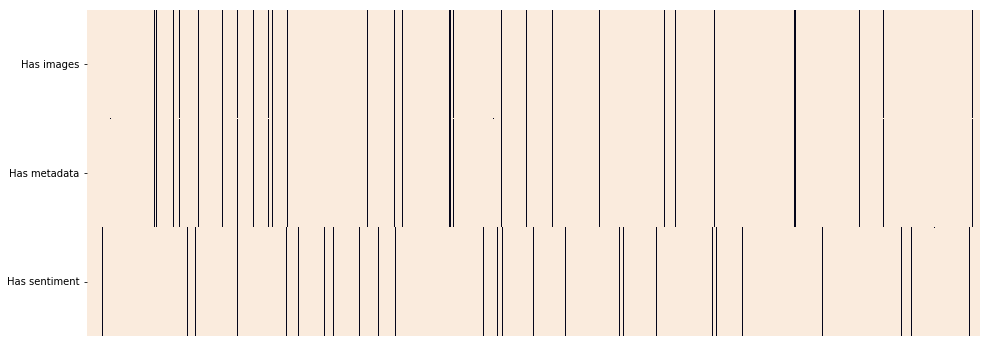

In [21]:
plt.figure(figsize=(16, 6))
cols = ['Has images', 'Has metadata', 'Has sentiment']
sns.heatmap(test_data_info[cols].sort_index().values.T,
            xticklabels=False,
            yticklabels=cols,
            cbar=False)
plt.yticks(rotation=0, va='center')
plt.ylabel(None)
plt.show()

## Overview of tabular data

The tabular data contains `AdoptionSpeed`, the attribute we are trying to predict. It is a categorical variable with five levels relating to how long it took for the animal to be adopted once it was listed on Petfinder.

**0**: Adopted in under 1 day <br>
**1**: Adopted in 1 to 7 days <br>
**2**: Adopted in 8 to 30 days <br>
**3**: Adopted in 31 to 90 days <br>
**4**: Adopted in at least 91 days <br>

There are lots of categorical variables in the data. Most are already encoded as integers - for example, the `Type` variable is 1 for a dog and 2 for a cat. This is a convenient form for training a model, but it doesn't much lend itself to EDA. So we'll make a copy of the data, replace the uninformative integers with more descriptive category labels, and use that version to make tables and plots.

### Relabeling categorical features

In [22]:
train = pd.read_csv('../data/train.csv', index_col='PetID')
breed_labels = pd.read_csv('../data/breed_labels.csv', index_col='BreedID', usecols=['BreedID', 'BreedName'])
color_labels = pd.read_csv('../data/color_labels.csv', index_col='ColorID')
state_labels = pd.read_csv('../data/state_labels.csv', index_col='StateID')

In [23]:
category_renaming = {
    'Type': {
        1: 'Dog',
        2: 'Cat'
    },
    'Gender': {
        1: 'Male',
        2: 'Female',
        3: 'Mixed'
    },
    'MaturitySize': {
        1: 'Small',
        2: 'Medium',
        3: 'Large',
        4: 'Extra Large',
        0: 'Not Specified'
    },
    'FurLength': {
        1: 'Short',
        2: 'Medium',
        3: 'Long',
        0: 'Not Specified'
    },
    'Vaccinated': {
        1: 'Yes',
        2: 'No',
        3: 'Not Sure'
    },
    'Dewormed': {
        1: 'Yes',
        2: 'No',
        3: 'Not Sure'
    },
    'Sterilized': {
        1: 'Yes',
        2: 'No',
        3: 'Not Sure'
    },
    'Health': {
        1: 'Healthy',
        2: 'Minor Injury',
        3: 'Serious Injury',
        0: 'Not Specified'
    },
    **state_labels.to_dict(), 
    **breed_labels.to_dict(), 
    **color_labels.to_dict()
}
# Zeros are not given in the supplementary data, so manually replace them with "none"
category_renaming['BreedName'][0] = 'None specified'
category_renaming['ColorName'][0] = 'None specified'
# Make sure the column names in the training data are reflected in the dictionary
category_renaming['Breed2'] = category_renaming['Breed1'] = category_renaming['BreedName']
category_renaming['Color3'] = category_renaming['Color2'] = category_renaming['Color1'] = category_renaming['ColorName']
# Don't need these for the actual renaming
del category_renaming['BreedName']
del category_renaming['ColorName']

In [24]:
train_eda = train.copy()
train_eda = train_eda.replace(category_renaming)

In [25]:
train_eda.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,,,
86e1089a3,Cat,Nibble,3,Tabby,None specified,Male,Black,White,None specified,Small,Short,No,No,No,Healthy,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2
6296e909a,Cat,No Name Yet,1,Domestic Medium Hair,None specified,Male,Black,Brown,None specified,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0
3422e4906,Dog,Brisco,1,Mixed Breed,None specified,Male,Brown,White,None specified,Medium,Medium,Yes,Yes,No,Healthy,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3
5842f1ff5,Dog,Miko,4,Mixed Breed,None specified,Female,Black,Brown,None specified,Medium,Short,Yes,Yes,No,Healthy,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2
850a43f90,Dog,Hunter,1,Mixed Breed,None specified,Male,Black,None specified,None specified,Medium,Short,No,No,No,Healthy,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2


[This Kaggle kernel](https://www.kaggle.com/artgor/exploration-of-data-step-by-step) has a nice way to visualize the response variable split out by categories, and I've used a slightly modified version here.

In [27]:
def prepare_diff_values(data, x, hue, groupby):
    if groupby not in ['hue', 'x']:
        raise ValueError
        
    total_pcts = data[hue].value_counts(normalize=True).sort_index()
    unique_levels = data[x].unique()
    diff_series = []
    
    flatten_order = 'C' if groupby == 'hue' else 'F'
    
    for level in unique_levels:
        level_pcts = data.loc[data[x] == level,hue].value_counts(normalize=True).sort_index()
        level_diffs = (level_pcts / total_pcts - 1) * 100
        level_diffs.name = level
        diff_series.append(level_diffs)
    
    diffs_df = pd.concat(diff_series, axis=1)
    diffs = diffs_df.values.flatten(flatten_order)
    
    return diffs

def format_text(d):
    if np.isnan(d):
        return '---%'
    if d <= 0:
        return f'{d:.1f}%'
    else:
        return f'+{d:.1f}%'

def text_color(d):
    if d <= 0:
        return 'red'
    else:
        return 'green'

def countplot(data, x, hue, groupby='hue', figsize=None, **kwargs):
    if groupby not in ['hue', 'x']:
        raise ValueError
        
    plt.figure(figsize=figsize)
    
    diff_values = prepare_diff_values(data, x, hue, groupby)
    
    if groupby == 'hue':
        g = sns.countplot(x=x, data=data, hue=hue, **kwargs)
        plt.title(f'Counts of {x} by {hue}')
    else:
        g = sns.countplot(x=hue, data=data, hue=x, **kwargs)
        plt.title(f'Counts of {hue} by {x}')
    
    ax = g.axes
    
    for p, d in zip(ax.patches, diff_values):
        height = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = format_text(d)
        color = text_color(d)
        ax.annotate(text,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center',
                    va='center',
                    fontsize=10,
                    color=color,
                    xytext=(0, 8),
                    textcoords='offset points')

Essentially a wrapper around [Seaborn's `countplot`](https://seaborn.pydata.org/generated/seaborn.countplot.html), this version of `countplot()` annotates the figure with the percent change in adoption speed rates by category versus the overall rate.

If we were to pick a listing entirely at random, there would be a 2.7% chance that pet was adopted on the same day (410 listings with `AdoptionSpeed` 0 out of 14,993 total listings). If we instead picked only from the cat listings, that chance jumps to 3.5% (240 listings with `AdoptionSpeed` 0 out of 6,861 total cat listings). That's about a 28% increase. By calculating those increases and annotating each bar with them, we can quickly tell what features of the data appear to influence `AdoptionSpeed`. In the plot below, we see that while there are fewer cats in the data set overall, they tend to be adopted faster than dogs.

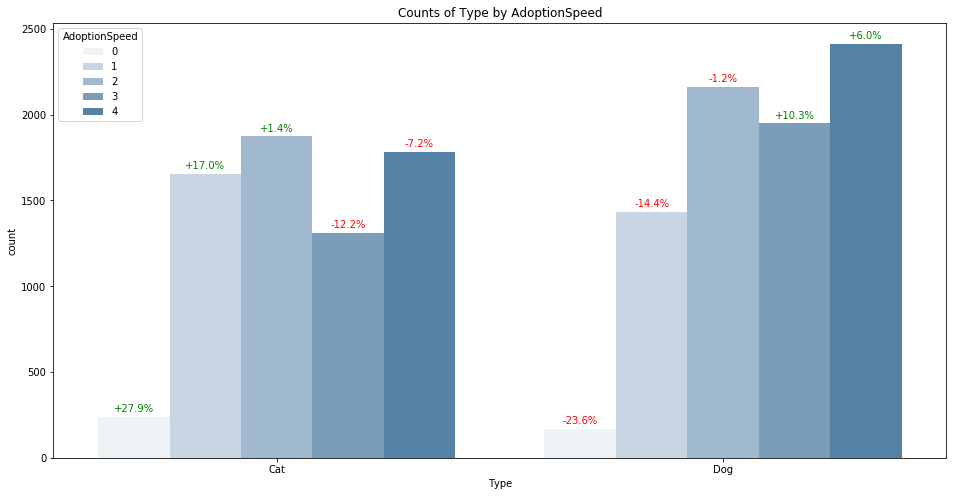

In [28]:
countplot(train_eda, 'Type', 'AdoptionSpeed', groupby='hue', figsize=(16, 8), color='steelblue')

### Missing values

The data are remarkably complete. The only features with missing data are `Name` and `Description`. `Name` is unlikely to be helpful for prediction at all, and `Description` is already being taken into account with the sentiment analysis, so it seems safe to drop these features.

In [26]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14993 entries, 86e1089a3 to a83d95ead
Data columns (total 23 columns):
Type             14993 non-null object
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null object
Breed2           14993 non-null object
Gender           14993 non-null object
Color1           14993 non-null object
Color2           14993 non-null object
Color3           14993 non-null object
MaturitySize     14993 non-null object
FurLength        14993 non-null object
Vaccinated       14993 non-null object
Dewormed         14993 non-null object
Sterilized       14993 non-null object
Health           14993 non-null object
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpeed    14993 non-nul

## Overview of sentiment analysis

In [48]:
import json
from tqdm import tqdm_notebook as tqdm

In [49]:
sentiment_files = list((datadir / 'train_sentiment').glob('*.json'))

In [50]:
sentiments = []
for sentiment_file in tqdm(sentiment_files):
    with open(sentiment_file) as f:
        data = json.load(f)
        sentiments.append(data)

In [54]:
pd.DataFrame(sentiments)

,categories,documentSentiment,entities,language,sentences,tokens
0,[],"{'magnitude': 0.5, 'score': 0}","[{'name': 'snout', 'type': 'OTHER', 'metadata'...",en,[{'text': {'content': 'Short snout Docked Tail...,[]
1,[],"{'magnitude': 8.3, 'score': 0.2}","[{'name': 'Ara', 'type': 'ORGANIZATION', 'meta...",en,[{'text': {'content': 'Ara needs a forever hom...,[]
2,[],"{'magnitude': 2.9, 'score': 0.3}","[{'name': 'Leia', 'type': 'PERSON', 'metadata'...",en,[{'text': {'content': 'Princess Leia was aband...,[]
3,[],"{'magnitude': 1.7, 'score': 0.4}","[{'name': 'Maru', 'type': 'OTHER', 'metadata':...",en,[{'text': {'content': 'Maru is very active and...,[]
4,[],"{'magnitude': 0.9, 'score': 0.9}","[{'name': 'friend', 'type': 'PERSON', 'metadat...",en,[{'text': {'content': 'This is Fernando.He ver...,[]
5,[],"{'magnitude': 0.7, 'score': 0.3}","[{'name': 'puppy', 'type': 'OTHER', 'metadata'...",en,[{'text': {'content': 'Female puppy rescued by...,[]
6,[],"{'magnitude': 1.1, 'score': 0.3}","[{'name': 'commitment', 'type': 'OTHER', 'meta...",en,[{'text': {'content': 'Adopters must vaccinate...,[]
7,[],"{'magnitude': 2.1, 'score': 0}","[{'name': 'cuties', 'type': 'OTHER', 'metadata...",en,[{'text': {'content': 'Both these cuties were ...,[]
8,[],"{'magnitude': 1.9, 'score': 0.2}","[{'name': 'kitten', 'type': 'PERSON', 'metadat...",en,[{'text': {'content': 'Stripe is a 3 months ol...,[]
9,[],"{'magnitude': 1.3, 'score': 0.3}","[{'name': 'Apple', 'type': 'ORGANIZATION', 'me...",en,"[{'text': {'content': 'Hi, Apple and her other...",[]


In [61]:
sentiments[0]['sentences']

[{'text': {'content': 'Short snout Docked Tail Good guard dog as he is very alert Only does his business on the grass and not on floor.',
   'beginOffset': -1},
  'sentiment': {'magnitude': 0.2, 'score': -0.2}},
 {'text': {'content': 'He could be train if you have the time to train him',
   'beginOffset': -1},
  'sentiment': {'magnitude': 0.2, 'score': 0.2}}]

In [64]:
sentiments[0]['entities']

[{'name': 'snout',
  'type': 'OTHER',
  'metadata': {},
  'salience': 0.30679742,
  'mentions': [{'text': {'content': 'snout', 'beginOffset': -1},
    'type': 'COMMON'}]},
 {'name': 'Tail',
  'type': 'OTHER',
  'metadata': {},
  'salience': 0.30679742,
  'mentions': [{'text': {'content': 'Tail', 'beginOffset': -1},
    'type': 'COMMON'}]},
 {'name': 'guard dog',
  'type': 'OTHER',
  'metadata': {},
  'salience': 0.12742628,
  'mentions': [{'text': {'content': 'guard dog', 'beginOffset': -1},
    'type': 'COMMON'}]},
 {'name': 'business',
  'type': 'OTHER',
  'metadata': {},
  'salience': 0.088674046,
  'mentions': [{'text': {'content': 'business', 'beginOffset': -1},
    'type': 'COMMON'}]},
 {'name': 'grass',
  'type': 'OTHER',
  'metadata': {},
  'salience': 0.088674046,
  'mentions': [{'text': {'content': 'grass', 'beginOffset': -1},
    'type': 'COMMON'}]},
 {'name': 'floor',
  'type': 'LOCATION',
  'metadata': {},
  'salience': 0.081630826,
  'mentions': [{'text': {'content': 'flo

In [62]:
pd.DataFrame(sentiments[0]['entities'])

,mentions,metadata,name,salience,type
0,"[{'text': {'content': 'snout', 'beginOffset': ...",{},snout,0.306797,OTHER
1,"[{'text': {'content': 'Tail', 'beginOffset': -...",{},Tail,0.306797,OTHER
2,"[{'text': {'content': 'guard dog', 'beginOffse...",{},guard dog,0.127426,OTHER
3,"[{'text': {'content': 'business', 'beginOffset...",{},business,0.088674,OTHER
4,"[{'text': {'content': 'grass', 'beginOffset': ...",{},grass,0.088674,OTHER
5,"[{'text': {'content': 'floor', 'beginOffset': ...",{},floor,0.081631,LOCATION


## Overview of image metadata